/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.9656, Val Loss: 0.7247, Train Acc: 67.57%, Val Acc: 75.46%
Epoch 2, Train Loss: 0.6658, Val Loss: 0.6823, Train Acc: 77.64%, Val Acc: 76.83%
Epoch 3, Train Loss: 0.5378, Val Loss: 0.7374, Train Acc: 81.97%, Val Acc: 75.72%
Epoch 4, Train Loss: 0.4459, Val Loss: 0.7283, Train Acc: 85.16%, Val Acc: 76.00%
Epoch 5, Train Loss: 0.3522, Val Loss: 0.6554, Train Acc: 88.14%, Val Acc: 78.82%


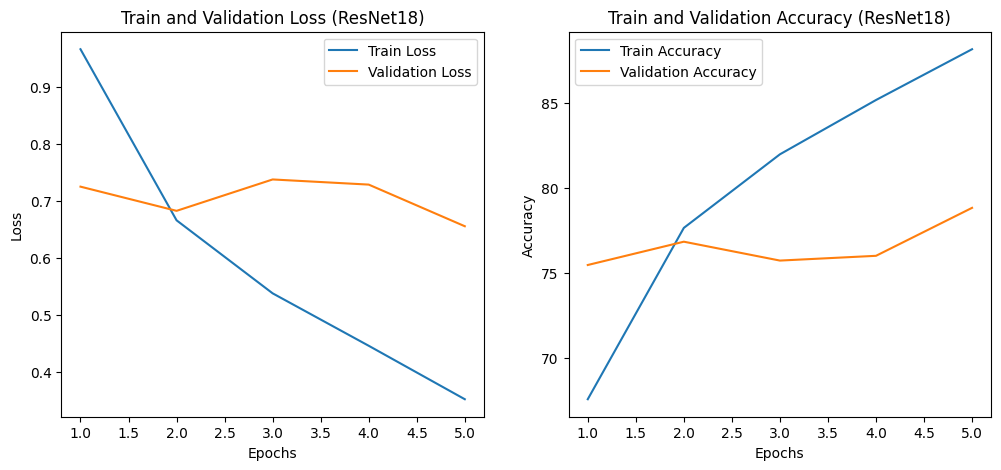

Test Accuracy: 78.82%


NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>

In [1]:
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# 加载CIFAR-10数据的函数，保持与VGG16一致
def load_cifar10_data(file_paths):
    X, y = [], []
    for file_path in file_paths:
        with open(file_path, 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
            X.append(batch[b'data'])
            y += batch[b'labels']
    X = np.vstack(X).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X = X.astype('float32') / 255.0  # 归一化
    y = np.array(y)
    return X, y

# 加载测试数据的函数
def load_test_batch(test_file_path):
    with open(test_file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        X_test = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32') / 255.0
        y_test = np.array(batch[b'labels'])
    return X_test, y_test

# 文件路径
train_file_paths = [
    'data_batch_1',
    'data_batch_2',
    'data_batch_3',
    'data_batch_4',
    'data_batch_5'
]
test_file_path = 'test_batch'

# 加载训练集和测试集数据
X_train, y_train = load_cifar10_data(train_file_paths)
X_test, y_test = load_test_batch(test_file_path)

# 将标签转换为one-hot编码
y_train = to_categorical(y_train, 10)  # CIFAR-10有10个类别
y_test = to_categorical(y_test, 10)

# 定义ResNet18模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)  # 修改输出层以适应 CIFAR-10 的 10 个类别
resnet18 = resnet18.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# 数据增强和归一化，与VGG16一致
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 训练集和测试集数据转换为PyTorch的DataLoader
trainset = torch.utils.data.TensorDataset(torch.Tensor(X_train).permute(0, 3, 1, 2), torch.LongTensor(np.argmax(y_train, axis=1)))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torch.utils.data.TensorDataset(torch.Tensor(X_test).permute(0, 3, 1, 2), torch.LongTensor(np.argmax(y_test, axis=1)))
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 训练模型并记录损失和准确率
def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(100 * correct_train / total_train)

        # 验证模型
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(testloader))
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# 调用 train_model 并记录学习曲线数据
train_losses, val_losses, train_accuracies, val_accuracies = train_model(resnet18, trainloader, testloader, criterion, optimizer, num_epochs=5)

# 绘制学习曲线
epochs = range(1, 6)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss (ResNet18)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy (ResNet18)')
plt.legend()

plt.show()

# 测试模型
def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    return all_preds, all_labels

# 测试模型并生成混淆矩阵
all_preds, all_labels = test_model(resnet18, testloader)

# 混淆矩阵
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for ResNet18 on CIFAR-10')
plt.show()


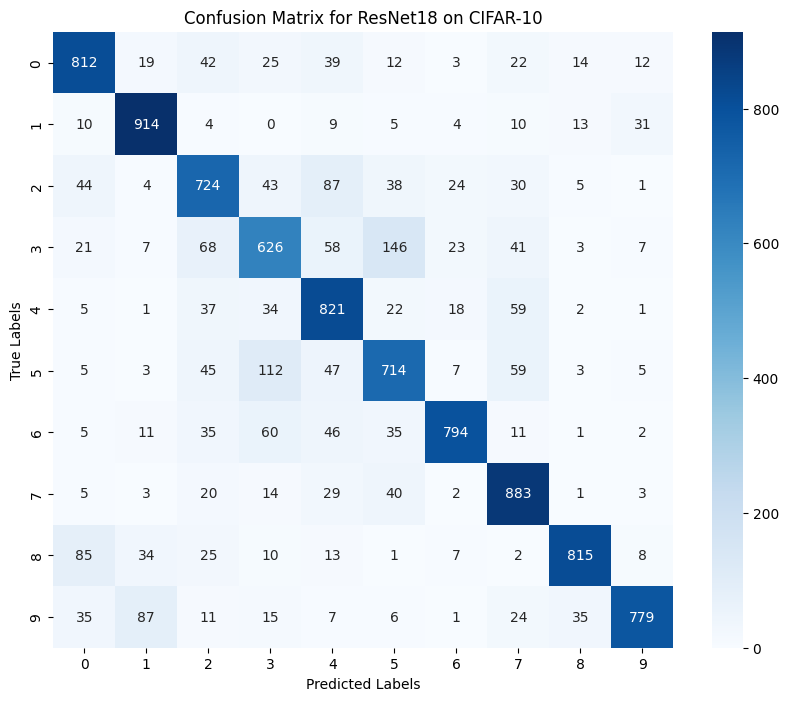

In [2]:
import seaborn as sns
# 混淆矩阵
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for ResNet18 on CIFAR-10')
plt.show()

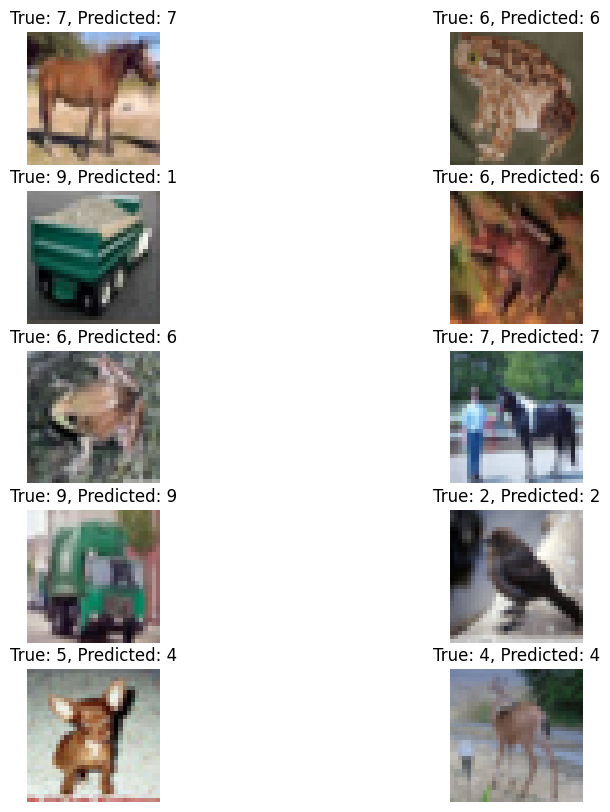

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 确保模型处于评估模式
resnet18.eval()

# 创建可视化预测和真实标签的图像
plt.figure(figsize=(10,10))
for i in range(10):
    index = np.random.randint(0, len(X_test))
    img = X_test[index]
    label = y_test[index]
    
    # 由于 ResNet 期望输入数据的形状为 [N, C, H, W]，我们需要转换形状
    img_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).to(device)  # [1, 3, 32, 32]

    # 将图像传入模型并得到预测
    with torch.no_grad():
        output = resnet18(img_tensor)
        pred_label = torch.argmax(output, dim=1).cpu().item()
    
    # 绘制图像和标签
    plt.subplot(5, 2, i+1)
    plt.imshow(img)  # 使用原始图像
    true_label = np.argmax(label)  # 获取真实标签
    plt.title(f'True: {true_label}, Predicted: {pred_label}')
    plt.axis('off')

plt.show()
